In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../..')
import mutagenesisfunctions as mf
import bpdev as bd
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import contacts

from Bio import AlignIO
import time as time
import pandas as pd
np.random.seed(42)

In [30]:
def vis_contacts(fam, comp='atom_dist', min_dist=8.0):

    ######### EXTRACT DATA ###########

    #extract SoM results after an APC correction
    arrayspath = 'Arrays/%s_mlp_%s.npy'%(fam,numhidden)
    hol_mut2 = np.load(arrayspath)
    seqlen,_, dims,_ = hol_mut2.shape
    C = bd.get_wc(arrayspath, seqlen, dims, bpugSQ=0, denoise='APC')

    #Load in the EC annotation
    ECannotfile = '%s/%s.EC.interaction.txt'%(fam,fam) 
    EC_df = pd.read_csv(ECannotfile, delimiter='\s+')

    ######### QUALITATIVE CONTACTS ###########

    #Get the top L/2 SoM scores
    bp_shade = bd.plot_wcrank(C, seqlen, seqlen//2)
    bp_shade[np.tril_indices(seqlen)] = 0.
    SoM_top = np.where(bp_shade > 0.)
    #Top L/2 EC scores
    topEC = EC_df.loc[:seqlen//2, ['Rfam_reduced_position1', 'Rfam_reduced_position2']]
    #All cWW annotated interactions
    cWW_int = EC_df[EC_df['interactions'] == 'cWW']
    #All PDB contacts < 8 angstroms
    close_cont = EC_df[EC_df['minimum_atom_distance'] <= min_dist] 
    
    #Retrieve Gtest
    filename = 'Arrays/marks_gtests.hdf5'
    with h5py.File(filename, 'r') as dataset:
        gtest = np.array(dataset['%s_gtest'%(fam)])
    #Get the top L/2 Gtest scores
    g_shade = bd.plot_wcrank(gtest, seqlen, seqlen//2)
    g_shade[np.tril_indices(seqlen)] = 0.
    gtest_top = np.where(g_shade > 0.)

    #plot
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(2,2,1)
    ax1.scatter(SoM_top[0], SoM_top[1], c='b', label = 'SoM')
    ax1.scatter(topEC.iloc[:,1], topEC.iloc[:,0], c='r', label = 'EC')
    ax1.set_title('SoM vs. top L/2 ECs')
    ax1.legend(loc='center right')

    ax2 = fig.add_subplot(2,2,2)
    ax2.scatter(SoM_top[0], SoM_top[1], c='b', label = 'SoM')
    ax2.scatter(cWW_int.iloc[:,2], cWW_int.iloc[:,1], c='m', label = 'cWW')
    ax2.set_title('SoM vs. all cWW contacts')
    ax2.legend(loc='center right')

    ax3 = fig.add_subplot(2,2,3)
    ax3.scatter(SoM_top[0], SoM_top[1], c='b', label = 'SoM')
    ax3.scatter(close_cont.iloc[:,2], close_cont.iloc[:,1], c='k', label = 'PDB contacts')
    ax3.set_title('SoM vs. contacts < %sA'%(min_dist))
    ax3.legend(loc='center right')
    
    ax4 = fig.add_subplot(2,2,4)
    ax4.scatter(SoM_top[0], SoM_top[1], c='b', label = 'SoM')
    ax4.scatter(gtest_top[1], gtest_top[0], c='g', label = 'MI with APC')
    ax4.set_title('SoM vs. top L/2 MI scores')
    ax4.legend(loc='center right')
    plt.axis('equal')
    
    plt.savefig('%s/Images_mlp/%s_contacts_vis_%sA.png'%(fam,fam,min_dist))
    plt.savefig('Contacts_vis/%s_contacts_vis_%sA.png'%(fam,min_dist))

    ######### QUANTITATIVE GRAPHS ###########

    #Get the real positive and negative pdb contacts
    def groundtruth(comp=comp):

        if comp == 'atom_dist':
            real_pos = np.zeros((seqlen,seqlen))
            for ii in range(len(close_cont)):
                real_pos[close_cont.iloc[ii, 1], close_cont.iloc[ii, 2]] = 1.
            real_neg = np.ones((seqlen,seqlen))
            for ii in range(len(close_cont)):
                real_neg[close_cont.iloc[ii, 1], close_cont.iloc[ii, 2]] = 0.
                
        if comp == 'cWW_int':
            real_pos = np.zeros((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_pos[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 1.
            real_neg = np.ones((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_neg[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 0.
        return (real_pos, real_neg)

    def sumstats_mi(thresh):
        #Get the top thresh Gtest scores
        g_pos = bd.plot_wcrank(gtest, seqlen, thresh*2)
        g_pos[np.tril_indices(seqlen)] = 0.
        #Get the bottom thresh SoM scores
        g_neg = (~g_pos.astype('bool'))*1 #incantation converts binary to boolean, flips them then back to binary

        TP = np.sum(real_pos*g_pos)
        FP = np.sum(real_neg*g_pos)
        TN = np.sum(real_neg*g_neg)
        FN = np.sum(real_pos*g_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV, FDR, TPR, TP, FP, TN, FN)
    
    def sumstats(thresh):
        #Get the top thresh SoM scores
        som_pos = bd.plot_wcrank(C, seqlen, thresh*2)
        som_pos[np.tril_indices(seqlen)] = 0.
        #Get the bottom thresh SoM scores
        som_neg = (~som_pos.astype('bool'))*1 #incantation converts binary to boolean, flips them then back to binary

        TP = np.sum(real_pos*som_pos)
        FP = np.sum(real_neg*som_pos)
        TN = np.sum(real_neg*som_neg)
        FN = np.sum(real_pos*som_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV, FDR, TPR, TP, FP, TN, FN)

    def sumstats_EC(thresh):
        #Top thresh EC scores
        n_EC_P = len(EC_df.iloc[:thresh, :])
        EC_pos = np.zeros((seqlen,seqlen))
        for ii in range(n_EC_P):
            EC_pos[EC_df.iloc[ii, 1], EC_df.iloc[ii, 2]] = 1.
        EC_neg = np.ones((seqlen,seqlen))
        for ii in range(n_EC_P):
            EC_neg[EC_df.iloc[ii, 1], EC_df.iloc[ii, 2]] = 0.

        TP = np.sum(real_pos*EC_pos)
        FP = np.sum(real_neg*EC_pos)
        TN = np.sum(real_neg*EC_neg)
        FN = np.sum(real_pos*EC_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV, FDR, TPR, TP, FP, TN, FN)
    
    real_pos, real_neg = groundtruth(comp=comp)
    extent = len(cWW_int)#seqlen

    EC_ppv = []
    EC_tpr = []
    SoM_ppv = []
    SoM_tpr = []
    g_ppv = []
    g_tpr = []
    for tr in range(extent):
        ecst = sumstats_EC(tr)
        somst = sumstats(tr)
        gst = sumstats_mi(tr)

        EC_ppv.append(ecst[0])
        EC_tpr.append(ecst[2])

        SoM_ppv.append(somst[0])
        SoM_tpr.append(somst[2])
        
        g_ppv.append(gst[0])
        g_tpr.append(gst[2])        
        

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(range(extent),SoM_ppv, '-b', label='SoM')
    ax1.plot(range(extent),EC_ppv, '-r', label='EC')
    ax1.plot(range(extent),g_ppv, '-g', label='MI')
    ax1.set_xlabel('Number of contacts predicted')
    ax1.set_ylabel('Positive Predictive Value')
    ax1.legend()

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(range(extent),SoM_tpr, 'b', label='SoM')
    ax2.plot(range(extent),EC_tpr, '-r', label='EC')
    ax2.plot(range(extent),g_tpr, '-g', label='MI')
    ax2.set_xlabel('Number of contacts predicted')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend()
    
    
    if comp == 'atom_dist':
        ax1.set_title('Contacts within %sA predicted'%(min_dist))
        ax2.set_title('Contacts within %sA predicted'%(min_dist))
        quanttitle = '%sA_contacts'%(min_dist)
    if comp == 'cWW_int':
        ax1.set_title('cWW interactions predicted')
        ax2.set_title('cWW interactions predicted')
        quanttitle = 'cWW_int_exww'
        
    plt.savefig('%s/Images_mlp/%s_%s_stats.png'%(fam,fam,quanttitle))
    plt.savefig('Stats_graphs/%s_%s_stats.png'%(fam, quanttitle))
    plt.close('all')
    
    ######### QUANTITATIVE CONTACTS ###########

In [2]:
#Load the SoM results file
families = ['RF00002', 'RF00005', 'RF00010', 'RF00017', 'RF00023', 'RF00050',
            'RF00059', 'RF00162', 'RF00167', 'RF00169', 'RF00174', 'RF00234',
            'RF00380', 'RF00504', 'RF01734', 'RF01786', 'RF01831', 'RF01852', 'RF02001']#, 'RF01960']

numhidden = 512

In [32]:
for fam in families:
    starttime = time.time()
    print (fam)
    vis_contacts(fam, min_dist=5.0, comp='atom_dist')
    vis_contacts(fam, min_dist=5.0, comp='cWW_int')
    print ('Graphs made:', mf.sectotime(time.time()-starttime))

RF00002


/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:139: RuntimeWarning: invalid value encountered in double_scalars
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:140: RuntimeWarning: invalid value encountered in double_scalars
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:118: RuntimeWarning: invalid value encountered in double_scalars
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:119: RuntimeWarning: invalid value encountered in double_scalars
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:100: RuntimeWarning: invalid value encountered in double_scalars
/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:101: RuntimeWarning: invalid value encountered in double_scalars


Graphs made: 15.03s
RF00005
Graphs made: 4.71s
RF00010
Graphs made: 1min 29.040000000000006s
RF00017
Graphs made: 59.1s
RF00023
Graphs made: 1min 32.370000000000005s
RF00050
Graphs made: 11.55s
RF00059
Graphs made: 7.61s
RF00162
Graphs made: 7.94s
RF00167
Graphs made: 7.39s
RF00169
Graphs made: 6.88s
RF00174
Graphs made: 21.64s
RF00234
Graphs made: 15.94s
RF00380
Graphs made: 17.82s
RF00504
Graphs made: 6.08s
RF01734
Graphs made: 4.0s
RF01786
Graphs made: 5.61s
RF01831
Graphs made: 7.0s
RF01852
Graphs made: 5.89s
RF02001
Graphs made: 18.36s


In [50]:
#Just calculate the MIs and save them for later access
#Perform Gtest
gtestsave = 'Arrays/marks_gtests.hdf5'
with h5py.File(gtestsave, 'w') as f:
    for fam in families:
        starttime = time.time()
        filename = '../../data_marks/%s/%s_red.hdf5'%(fam, fam)
        with h5py.File(filename, 'r') as dataset:
            X_data = np.array(dataset['X_data'])
        numdata = X_data.shape[0]
        X_data = X_data[:numdata//2, :, 0, :4]
        gtest = contacts.g_test(X_data)
        gtest[np.isnan(gtest)] = 0.
        gtest = contacts.apc_correction(gtest)
        f.create_dataset('%s_gtest'%(fam), data=gtest.astype(np.float32), compression='gzip')
        print (fam)
        print ('Gtest and saving:', mf.sectotime(time.time()-starttime))

RF00002
Gtest and saving: 13min 12.07000000000005s
RF00005
Gtest and saving: 2min 4.829999999999998s
RF00010
Gtest and saving: 50.03s
RF00017
Gtest and saving: 2min 35.83000000000001s
RF00023
Gtest and saving: 52.39s
RF00050
Gtest and saving: 5.21s
RF00059
Gtest and saving: 8.24s
RF00162
Gtest and saving: 3.66s
RF00167
Gtest and saving: 1.86s
RF00169
Gtest and saving: 3.42s
RF00174
Gtest and saving: 21.87s
RF00234
Gtest and saving: 1.68s
RF00380
Gtest and saving: 3.14s
RF00504
Gtest and saving: 3.51s
RF01734
Gtest and saving: 0.39s
RF01786
Gtest and saving: 0.24s
RF01831
Gtest and saving: 0.52s
RF01852
Gtest and saving: 1.06s
RF02001
Gtest and saving: 4.86s


In [5]:
#Just calculate the MIs and save them for later access
#Perform normal MI
gtestsave = 'Arrays/marks_MI.hdf5'
with h5py.File(gtestsave, 'w') as f:
    for fam in ['RF00162']:
        starttime = time.time()
        filename = '../../data_marks/%s/%s_red.hdf5'%(fam, fam)
        with h5py.File(filename, 'r') as dataset:
            X_data = np.array(dataset['X_data'])
        numdata = X_data.shape[0]
        X_data = X_data[:numdata//2, :, 0, :4]
        MI = contacts.mutual_information(X_data)
        MI[np.isnan(MI)] = np.min(MI)
        MI = contacts.apc_correction(MI)
        f.create_dataset('%s_MI'%(fam), data=MI.astype(np.float32), compression='gzip')
        print (fam)
        print ('MI calculation and saving:', mf.sectotime(time.time()-starttime))

RF00162
MI calculation and saving: 10.79s


In [ ]:
ec_col = EC_df.loc[:seqlen//2, ['score']]
som_col = [C[ii,jj] for ii,jj in zip(SoM_top[0],SoM_top[1])]

# Get performance metrics

In [2]:
metricfile = 'test_metrics.csv'
metrics = pd.read_csv(metricfile)[['Model Architecture', 'Family', 'Accuracy']]
mlp_met = metrics[metrics['Model Architecture'] == 'mlp']
redidx = [False if 'bpm' in e else True for e in mlp_met['Family']]
mlp_met = mlp_met[redidx]
metfamidx = mlp_met.set_index('Family')['Accuracy']
mlp_met.head()

,Model Architecture,Family,Accuracy
0,mlp,RF00002,0.999774
1,mlp,RF00005,0.999414
2,mlp,RF00010,0.999219
3,mlp,RF00017,0.997576
4,mlp,RF00023,0.999165


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


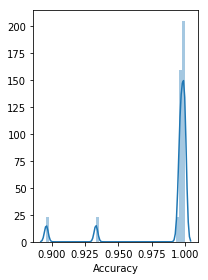

In [7]:
plt.figure(figsize=(3,4))

#sb.stripplot(y='Accuracy', data=mlp_met, jitter=True,
#             edgecolor='k', color='r',size=10, linewidth=1.5)
#plt.ylim([0.85, 1.02])
#plt.yticks(np.linspace(0.85,1.0,7))

sb.distplot(mlp_met['Accuracy'])

plt.show()

In [16]:
binranges = np.arange(0.86, 1.02, 0.02)
accs = np.array(mlp_met['Accuracy'])
bins=[]
for ii in range(len(binranges[:-1])):
    bins.append(accs[np.where((accs >= binranges[ii]) & (accs <= binranges[ii+1]))])
    

# Contact vis compared to infernal SS

In [18]:
#first get the nested SS (from R-scape for now)
#open the sto file to see if pseudoknots are present
fam = 'RF00023'
cykfile = '../../data_marks/%s/%s_red.cyk.sto'%(fam,fam)
SS = ''
with open(cykfile, 'r') as f1:
    for line in f1:
        if line[:13] == '#=GC SS_cons ':
            line = line.split()
            SS = SS + line[2]
            
nest_coords = bd.bp_coords(SS)
nest_coords = nest_coords[:len(nest_coords)//2]

In [82]:
fam = 'RF00023'

arrayspath = 'Arrays/%s_mlp_%s_red.npy'%(fam,numhidden)
hol_mut2 = np.load(arrayspath)
seqlen,_, dims,_ = hol_mut2.shape
C = bd.get_wc(arrayspath, seqlen, dims, bpugSQ=0, denoise='APC')
C[np.tril_indices(seqlen)] = np.min(C)
bp_stretch = np.ravel(C)
minval = np.sort(bp_stretch)[::-1][-1]
bs = np.where(C > minval)
idx = np.argsort(C[bs])[::-1]
x = bs[0][idx][::-1]
y = bs[1][idx][::-1]

cols = [C[xx,yy] for xx,yy in zip(x,y)]


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


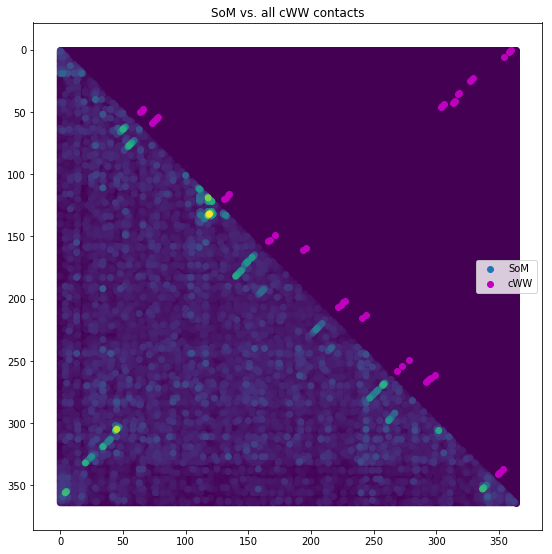

In [105]:
######### EXTRACT DATA ###########

numhidden = 512
min_dist = 5.0

#extract SoM results after an APC correction
arrayspath = 'Arrays/%s_mlp_%s_red.npy'%(fam,numhidden)
hol_mut2 = np.load(arrayspath)
seqlen,_, dims,_ = hol_mut2.shape
C = bd.get_wc(arrayspath, seqlen, dims, bpugSQ=0, denoise='APC')

#Load in the EC annotation
ECannotfile = '%s/%s.EC.interaction.txt'%(fam,fam) 
EC_df = pd.read_csv(ECannotfile, delimiter='\s+')

######### QUALITATIVE CONTACTS ###########

#Get the top L/2 SoM scores
bp_shade = bd.plot_wcrank(C, seqlen, seqlen//2)
bp_shade[np.tril_indices(seqlen)] = 0.
SoM_top = np.where(bp_shade > 0.)
#Top L/2 EC scores
topEC = EC_df.loc[:seqlen//2, ['Rfam_reduced_position1', 'Rfam_reduced_position2']]
#All cWW annotated interactions
cWW_int = EC_df[EC_df['interactions'] == 'cWW']
#All PDB contacts < 8 angstroms
close_cont = EC_df[EC_df['minimum_atom_distance'] <= min_dist] 

#plot
'''
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(cWW_int.iloc[:,1], cWW_int.iloc[:,2], c='r', label = 'SoM')
ax1.scatter(cWW_int.iloc[:,2], cWW_int.iloc[:,1], c='m', label = 'cWW')
ax1.set_title('SoM vs. all cWW contacts')
ax1.legend(loc='center right')

'''
som_col = [C[ii,jj] for ii,jj in zip(SoM_top[0],SoM_top[1])]
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(np.tril_indices(seqlen)[0], np.tril_indices(seqlen)[1], c=np.asarray([cmap(0.)]))
ax1.scatter(x, y, c=cols, cmap='viridis', label = 'SoM', vmin=0.)
#ax1.scatter(SoM_top[0], SoM_top[1], c=som_col, cmap='hot_r', label = 'SoM')
ax1.scatter(cWW_int.iloc[:,2], cWW_int.iloc[:,1], c='m', label = 'cWW')
ax1.set_title('SoM vs. all cWW contacts')
ax1.legend(loc='center right')

'''
ax2 = fig.add_subplot(2,2,2)
ax2.scatter(nest_coords[:, 0], nest_coords[:, 1], c='r', label = 'nested')
ax2.scatter(cWW_int.iloc[:,2], cWW_int.iloc[:,1], c='m', label = 'cWW')
ax2.set_title('Nested base pairs vs. all cWW contacts')
ax2.legend(loc='center right')
'''
plt.gca().invert_yaxis()
plt.show()

In [104]:
import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')

rgba = cmap(0.5)
np.asarray([cmap(0.)]).shape

(1, 4)

# Compare PPV/TPR of families at a particular threshold

In [6]:
def quant_contacts(fam, comp='cWW_int', min_dist=5.0):
# using the threshold of L/2
    ######### EXTRACT DATA ###########

    #extract SoM results after an APC correction
    arrayspath = 'Arrays/%s_mlp_%s_red.npy'%(fam,numhidden)
    hol_mut2 = np.load(arrayspath)
    seqlen,_, dims,_ = hol_mut2.shape
    C = bd.get_wc(arrayspath, seqlen, dims, bpugSQ=0, denoise='APC')

    #Load in the EC annotation
    ECannotfile = '%s/%s.EC.interaction.txt'%(fam,fam) 
    EC_df = pd.read_csv(ECannotfile, delimiter='\s+')

    ######### QUALITATIVE CONTACTS ###########
    #All cWW annotated interactions
    cWW_int = EC_df[EC_df['interactions'] == 'cWW']
    #All PDB contacts < 8 angstroms
    close_cont = EC_df[EC_df['minimum_atom_distance'] <= min_dist] 

    ######### QUANTITATIVE GRAPHS ###########

    #Get the real positive and negative pdb contacts
    def groundtruth(comp=comp):

        if comp == 'atom_dist':
            real_pos = np.zeros((seqlen,seqlen))
            for ii in range(len(close_cont)):
                real_pos[close_cont.iloc[ii, 1], close_cont.iloc[ii, 2]] = 1.
            real_neg = np.ones((seqlen,seqlen))
            for ii in range(len(close_cont)):
                real_neg[close_cont.iloc[ii, 1], close_cont.iloc[ii, 2]] = 0.
                
        if comp == 'cWW_int':
            real_pos = np.zeros((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_pos[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 1.
            real_neg = np.ones((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_neg[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 0.
        return (real_pos, real_neg)

    def sumstats_mi(thresh):
        #Get the top thresh Gtest scores
        g_pos = bd.plot_wcrank(gtest, seqlen, thresh*2)
        g_pos[np.tril_indices(seqlen)] = 0.
        #Get the bottom thresh SoM scores
        g_neg = (~g_pos.astype('bool'))*1 #incantation converts binary to boolean, flips them then back to binary

        TP = np.sum(real_pos*g_pos)
        FP = np.sum(real_neg*g_pos)
        TN = np.sum(real_neg*g_neg)
        FN = np.sum(real_pos*g_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV, FDR, TPR, TP, FP, TN, FN)
    
    def sumstats(thresh):
        #Get the top thresh SoM scores
        som_pos = bd.plot_wcrank(C, seqlen, thresh*2)
        som_pos[np.tril_indices(seqlen)] = 0.
        #Get the bottom thresh SoM scores
        som_neg = (~som_pos.astype('bool'))*1 #incantation converts binary to boolean, flips them then back to binary

        TP = np.sum(real_pos*som_pos)
        FP = np.sum(real_neg*som_pos)
        TN = np.sum(real_neg*som_neg)
        FN = np.sum(real_pos*som_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV, FDR, TPR, TP, FP, TN, FN)

    def sumstats_EC(thresh):
        #Top thresh EC scores
        n_EC_P = len(EC_df.iloc[:thresh, :])
        EC_pos = np.zeros((seqlen,seqlen))
        for ii in range(n_EC_P):
            EC_pos[EC_df.iloc[ii, 1], EC_df.iloc[ii, 2]] = 1.
        EC_neg = np.ones((seqlen,seqlen))
        for ii in range(n_EC_P):
            EC_neg[EC_df.iloc[ii, 1], EC_df.iloc[ii, 2]] = 0.

        TP = np.sum(real_pos*EC_pos)
        FP = np.sum(real_neg*EC_pos)
        TN = np.sum(real_neg*EC_neg)
        FN = np.sum(real_pos*EC_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV, FDR, TPR, TP, FP, TN, FN)
    
    real_pos, real_neg = groundtruth(comp=comp)
    #ecst = sumstats_EC(tr)
    somst = sumstats(seqlen//2)
    #gst = sumstats_mi(tr)
    
    return (somst[0], somst[2])


In [7]:
PPVs = []
TPRs = []
families = ['RF00002', 'RF00005', 'RF00010', 'RF00017', 'RF00023', 'RF00050',
            'RF00059', 'RF00162', 'RF00167', 'RF00169', 'RF00174', 'RF00234',
            'RF00380', 'RF00504', 'RF01734', 'RF01786', 'RF01831', 'RF01852', 'RF02001']#, 'RF01960']

numhidden = 512

for fam in families:
    s = quant_contacts(fam)
    PPVs.append(s[0])
    TPRs.append(s[1])

### Get the number of Watson crick base pairs per family

In [8]:

numbasepairs = {}
for fam in families:
    ECannotfile = '%s/%s.EC.interaction.txt'%(fam,fam) 
    EC_df = pd.read_csv(ECannotfile, delimiter='\s+')
    #All cWW annotated interactions
    cWW_int = EC_df[EC_df['interactions'] == 'cWW']
    numbasepairs[fam] = len(cWW_int)

In [9]:
#import length information
infofile = 'marks_20_cutinfo.csv'
infodf = pd.read_csv(infofile)
#only get relevant families
inforel = infodf[[True if infodf.loc[ii, 'RFAM_ID'] in families else False for ii in infodf.index]]
#Add a new column that is the ratio of the depth/length (higher depth and lower length should be better)
inforel['M:L'] = inforel['M']/inforel['Length']
inforel['M_eff:L'] = inforel['M_eff']/inforel['Length']
#Add stats information
inforel['PPV'] = pd.Series(PPVs, index=inforel.index)
inforel['TPR'] = pd.Series(TPRs, index=inforel.index)
#Add accuracy from metricsdf and numbasepairs
for ii in inforel.index:
    inforel.loc[ii, 'Accuracy'] = metfamidx[inforel.loc[ii,'RFAM_ID']]
    inforel.loc[ii, 'Numbp'] = numbasepairs[inforel.loc[ii,'RFAM_ID']]

#Add a bp:length ratio
inforel['bp:L'] =inforel['Numbp']/inforel['Length']


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [10]:
inforel.head()

,RFAM_ID,Name,Length,M,M_eff,M:L,M_eff:L,PPV,TPR,Accuracy,Numbp,bp:L
0,RF00002,5.8S ribosomal RNA,155,375612,1197.3,2423.303226,7.724516,0.012987,0.037037,0.999774,27.0,0.174194
1,RF00005,tRNA,73,298470,3533.2,4088.630137,48.400000,0.416667,0.882353,0.999414,17.0,0.232877
2,RF00010,Bacterial RNase P class A,359,6397,1215.1,17.818942,3.384680,0.430168,0.762376,0.999219,101.0,0.281337
3,RF00017,Metazoan signal recognition particle RNA,300,22685,4358.5,75.616667,14.528333,0.060403,0.225000,0.997576,40.0,0.133333
4,RF00023,transfer-messenger RNA,366,5983,1558.9,16.346995,4.259290,0.197802,0.720000,0.999165,50.0,0.136612


Visualize
I think that the structure learning will scale with the ratio of depth and length. I wanna see if there are any clear trends when I compare the length metrics to the performance metrics. I can use catplot (maybe)

meltdf= pd.melt(plotdf, id_vars=['Genotype', 'Sex'], var_name=\"Gene\", value_name=\"TPM\")\n",

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


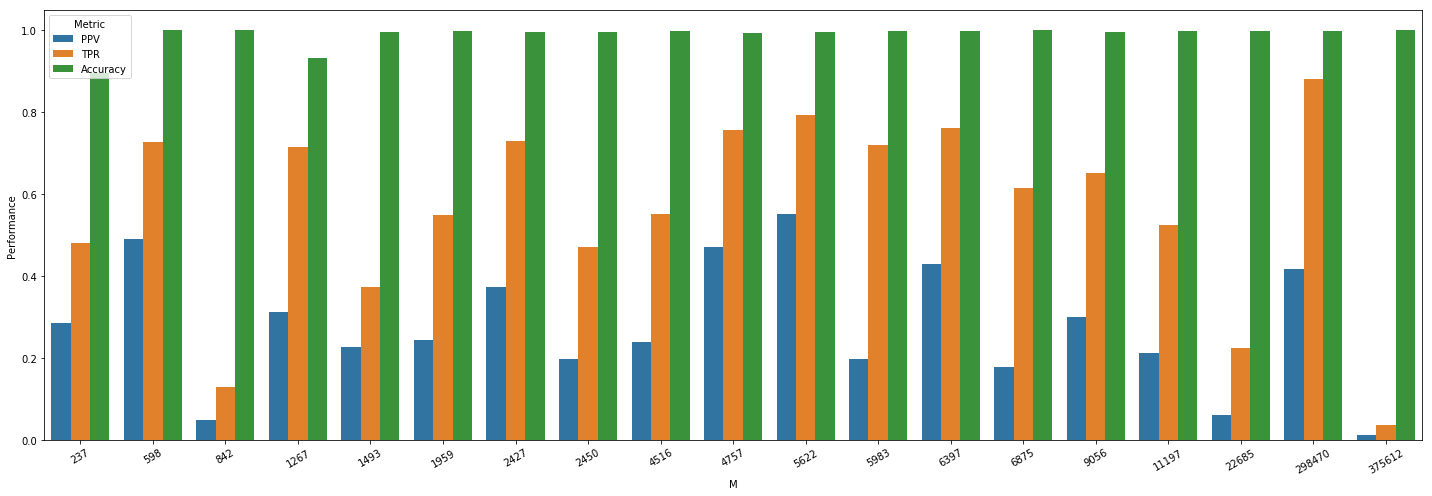

In [81]:
relsort = inforel.sort_values('M')
meltsort = pd.melt(relsort, id_vars=['RFAM_ID', 'Name', 'M', 'M_eff'],
                   value_vars=['PPV', 'TPR', 'Accuracy'], var_name='Metric', value_name='Performance')
plt.figure(figsize=(20,7))
b = sb.barplot(data = meltsort, x='M', y='Performance', hue='Metric')
b.set_xticklabels(labels=meltsort['M'],rotation=30)
plt.show()

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


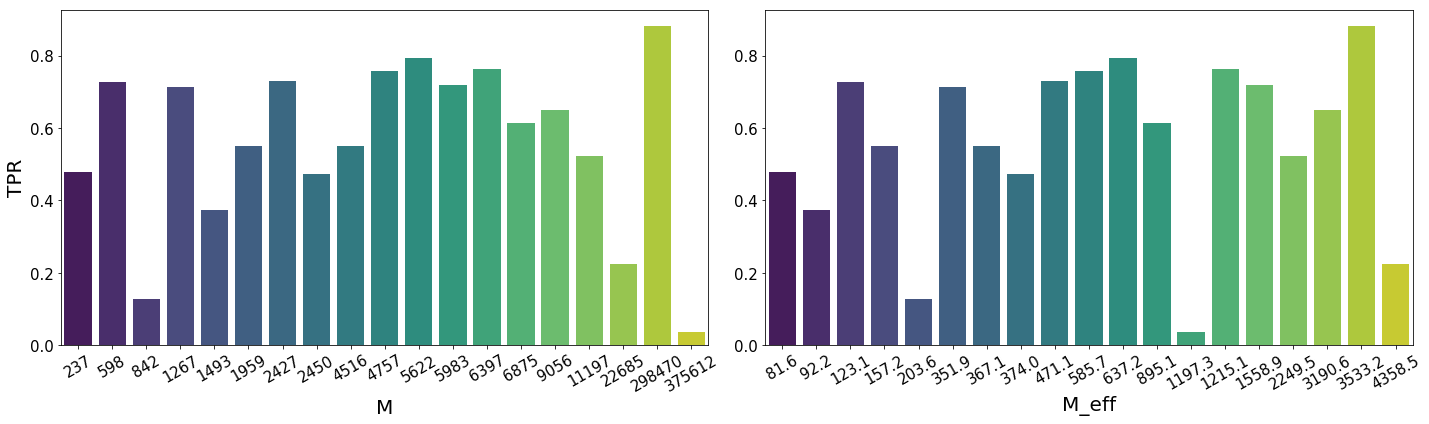

In [28]:
fig = plt.figure(figsize=(20,6))

var = 'M_eff'
relsort = inforel.sort_values(var)
ax1 = fig.add_subplot(1,2,1)
ax1 = sb.barplot(data = inforel.sort_values('M'), x='M', y='TPR', palette='viridis')
ax1.set_xticklabels(labels=inforel.sort_values('M')['M'],rotation=30)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_ylabel(ylabel='TPR', fontsize=20)
ax1.set_xlabel(xlabel='M', fontsize=20)
#ax1.set_ylim([0.8,1])

ax2 = fig.add_subplot(1,2,2)
ax2 = sb.barplot(data = relsort, x=var, y='TPR', palette='viridis')
ax2.set_xticklabels(labels=relsort[var],rotation=30)
ax2.set_ylabel(ylabel='')
ax2.set_xlabel(xlabel='M_eff', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [14]:
inforel

,RFAM_ID,Name,Length,M,M_eff,M:L,M_eff:L,PPV,TPR,Accuracy,Numbp,bp:L
0,RF00002,5.8S ribosomal RNA,155,375612,1197.3,2423.303226,7.724516,0.012987,0.037037,0.999774,27.0,0.174194
1,RF00005,tRNA,73,298470,3533.2,4088.630137,48.400000,0.416667,0.882353,0.999414,17.0,0.232877
2,RF00010,Bacterial RNase P class A,359,6397,1215.1,17.818942,3.384680,0.430168,0.762376,0.999219,101.0,0.281337
3,RF00017,Metazoan signal recognition particle RNA,300,22685,4358.5,75.616667,14.528333,0.060403,0.225000,0.997576,40.0,0.133333
4,RF00023,transfer-messenger RNA,366,5983,1558.9,16.346995,4.259290,0.197802,0.720000,0.999165,50.0,0.136612
5,RF00050,FMN riboswitch (RFN element),135,4516,367.1,33.451852,2.719259,0.238806,0.551724,0.997788,29.0,0.214815
6,RF00059,TPP riboswitch (THI element),105,11197,2249.5,106.638095,21.423810,0.211538,0.523810,0.998661,21.0,0.200000
7,RF00162,SAM riboswitch (S box leader),108,4757,585.7,44.046296,5.423148,0.471698,0.757576,0.994748,33.0,0.305556
8,RF00167,Purine riboswitch,103,2427,471.1,23.563107,4.573786,0.372549,0.730769,0.995885,26.0,0.252427
9,RF00169,Bacterial small signal recognition particle RNA,99,5622,637.2,56.787879,6.436364,0.551020,0.794118,0.996448,34.0,0.343434


<Figure size 1440x504 with 0 Axes>

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


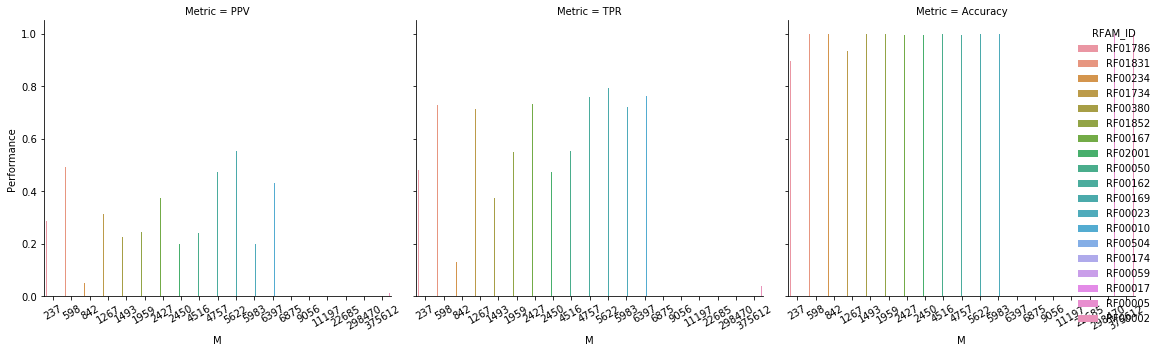

In [44]:
#meltsort['M'] = meltsort['M'].apply(str)
plt.figure(figsize=(20,7))
b = sb.catplot(data = meltsort, x='M', y='Performance', col='Metric', hue='RFAM_ID', kind='bar')
b.set_xticklabels(labels=meltsort['M'],rotation=30)
plt.show()

<Figure size 432x288 with 0 Axes>

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


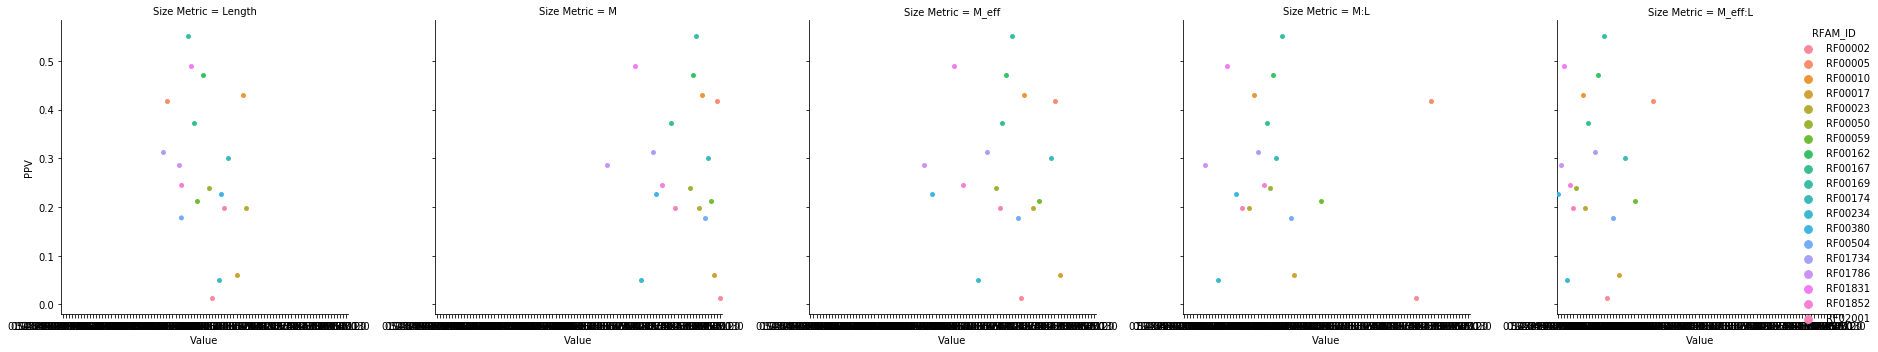

In [165]:
#visualize
meltinfo = pd.melt(inforel, id_vars=['RFAM_ID', 'Name', 'PPV', 'TPR'], var_name='Size Metric', value_name='Value')
plt.figure()
sb.catplot(data=meltinfo, x='Value', y='PPV', col='Size Metric', hue='RFAM_ID')
plt.show()

There seems to be no correlation between the variables comprising the size of the matrix, and the performance of the model.